In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import warnings

## plotting
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize # , DivergingNorm
import cmcrameri.cm as ccm
from matplotlib.cm import ScalarMappable

## custom
from dirs import wrfdir, basedir, coorddir, snoteldir, outputsdir

plt.style.use('style.mplstyle')
plt.rcParams['font.family'] = 'sans-serif'

warnings.filterwarnings("ignore")

/global/homes/c/cowherd/.conda/envs/resilient-snowpack-estimation/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
huc2 = gpd.read_file(f'{basedir}data/huc2.shp')
huc6 = gpd.read_file(f'{basedir}data/wus_huc6.shp')
coords = xr.open_dataset(f'{coorddir}wrfinput_d02')
states = gpd.read_file(f'{basedir}/data/cb_2018_us_state_5m.shp')
sweMax = xr.open_dataset(f'{basedir}/data/tmp/snowMax.nc').compute().rename({'__xarray_dataarray_variable__': 'swe'})
basin_masks = xr.open_dataset(f'{outputsdir}basin_masks_filtered.nc')
err = xr.open_dataset(f'{outputsdir}/Err_allmodels_corrupteddata.nc').rename({'__xarray_dataarray_variable__':'value'})
exclude_value = "Northern Oregon Coastal" ## low snow, does not make sense to include due to near-0 denominator
mask = err["basin"] != exclude_value
err = err.where(mask, drop=True)

In [3]:
## list parameters
models = err.model.values
gcms = err.gcm.values
basins = err.basin.values
years = err.test_year.values
datas = err.pred_combo.values
metrics = err.metric.values


In [4]:
#datas = ['Data_1', 'Data_2', 'Data_3', 'Data_4','Data_5']
#basin_names = h6masks['basin'].data
#basin_names = basin_names[basin_names != 'Northern Oregon Coastal']
norm = Normalize(vmin=0, vmax=1)
colormap =  ccm.acton_r #plt.cm.get_cmap("viridis")  
colormap = plt.cm.get_cmap('plasma_r')
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

norm2 = Normalize(vmin=-1, vmax=1)
colormap2 = ccm.roma # plt.cm.get_cmap("BrBG")  
sm2 = ScalarMappable(cmap=colormap, norm=norm)
sm2.set_array([])



In [5]:
##just generate the numbers and save it and then plot them in the second oe
outdatas = {}
for i,data in enumerate(datas):
    outdatas[i] = {}
    for j,model in enumerate(models):
        outdatas[i][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = np.nanmean(err.sel(metric = 'r2').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value'].values)
            basin = huc6[huc6.name == name]
            outdatas[i][model].append(mydata)


In [6]:
##just generate the numbers and save it and then plot them in the second oe
outrmse = {}
for i,data in enumerate(datas):
    outrmse[i] = {}
    for j,model in enumerate(models):
        outrmse[i][model] = []
        for n in range(len(basins)):
            name = basins[n]
            mydata = np.nanmean(err.sel(metric = 'rmse').sel(basin = name).sel(pred_combo = data).sel(model = model).mean(dim = 'gcm')['value'].values)
            basin = huc6[huc6.name == name]
            outrmse[i][model].append(mydata)

In [7]:
geometry = []
for name in basins:
    idx = huc6[huc6.name == name].index[0]
    geometry.append(huc6[huc6.name == name].loc[idx]['geometry'])
plotdata = gpd.GeoDataFrame({'basin_name':basins, 'geometry':geometry})

for i,data in enumerate(datas):
    for j,model in enumerate(models):
        colname = f'{data}_{model}'
        plotdata[colname] = outdatas[i][model]
    plotdata[f'{data}_diff'] = np.array(outdatas[i]['linreg']) - np.array(outdatas[i]['RF'] )

In [8]:
groups = {'grp1': ['Data_1', 'Data_2'],
          'grp2': ['Data_3', 'Data_4'],
          'grp3': ['Data_5']}
def plot_model_grp_ax(model, grp, ax):
    tmp_data = err.sel(metric = 'r2').sel(pred_combo = groups[grp]).sel(model = model).mean(dim = 'gcm').mean(dim = 'pred_combo')
    yearmeans = np.nanmean(np.array(tmp_data.value), axis =1)

    tmp_gdf = gpd.GeoDataFrame({'mean':yearmeans}, geometry = geometry)
    tmp_gdf.plot(ax=ax, column = 'mean', vmin = 0, vmax = 1)
    return


In [9]:
import pandas as pd
groups = {
    'RF_data_1_2': ['Data_1_RF', 'Data_2_RF'],
    'RF_data_3_4': ['Data_3_RF', 'Data_4_RF'],
    'RF_data_5': ['Data_5_RF'],
    'linreg_data_1_2': ['Data_1_linreg', 'Data_2_linreg'],
    'linreg_data_3_4': ['Data_3_linreg', 'Data_4_linreg'],
    'linreg_data_5': ['Data_5_linreg'],
    'Unet_data_1_2': ['Data_1_Unet', 'Data_2_Unet'],
    'Unet_data_3_4': ['Data_3_Unet', 'Data_4_Unet'],
    'Unet_data_5': ['Data_5_Unet']
}

# Calculate the means for each group and store them in a new DataFrame
means_data = {}
for group_name, group_columns in groups.items():
    means_data[group_name] = plotdata[group_columns].mean(axis=1)

grouped_df = pd.DataFrame(means_data)
grouped_df['basin_name'] = plotdata['basin_name']
grouped_gdf = gpd.GeoDataFrame(grouped_df, geometry = plotdata.geometry)


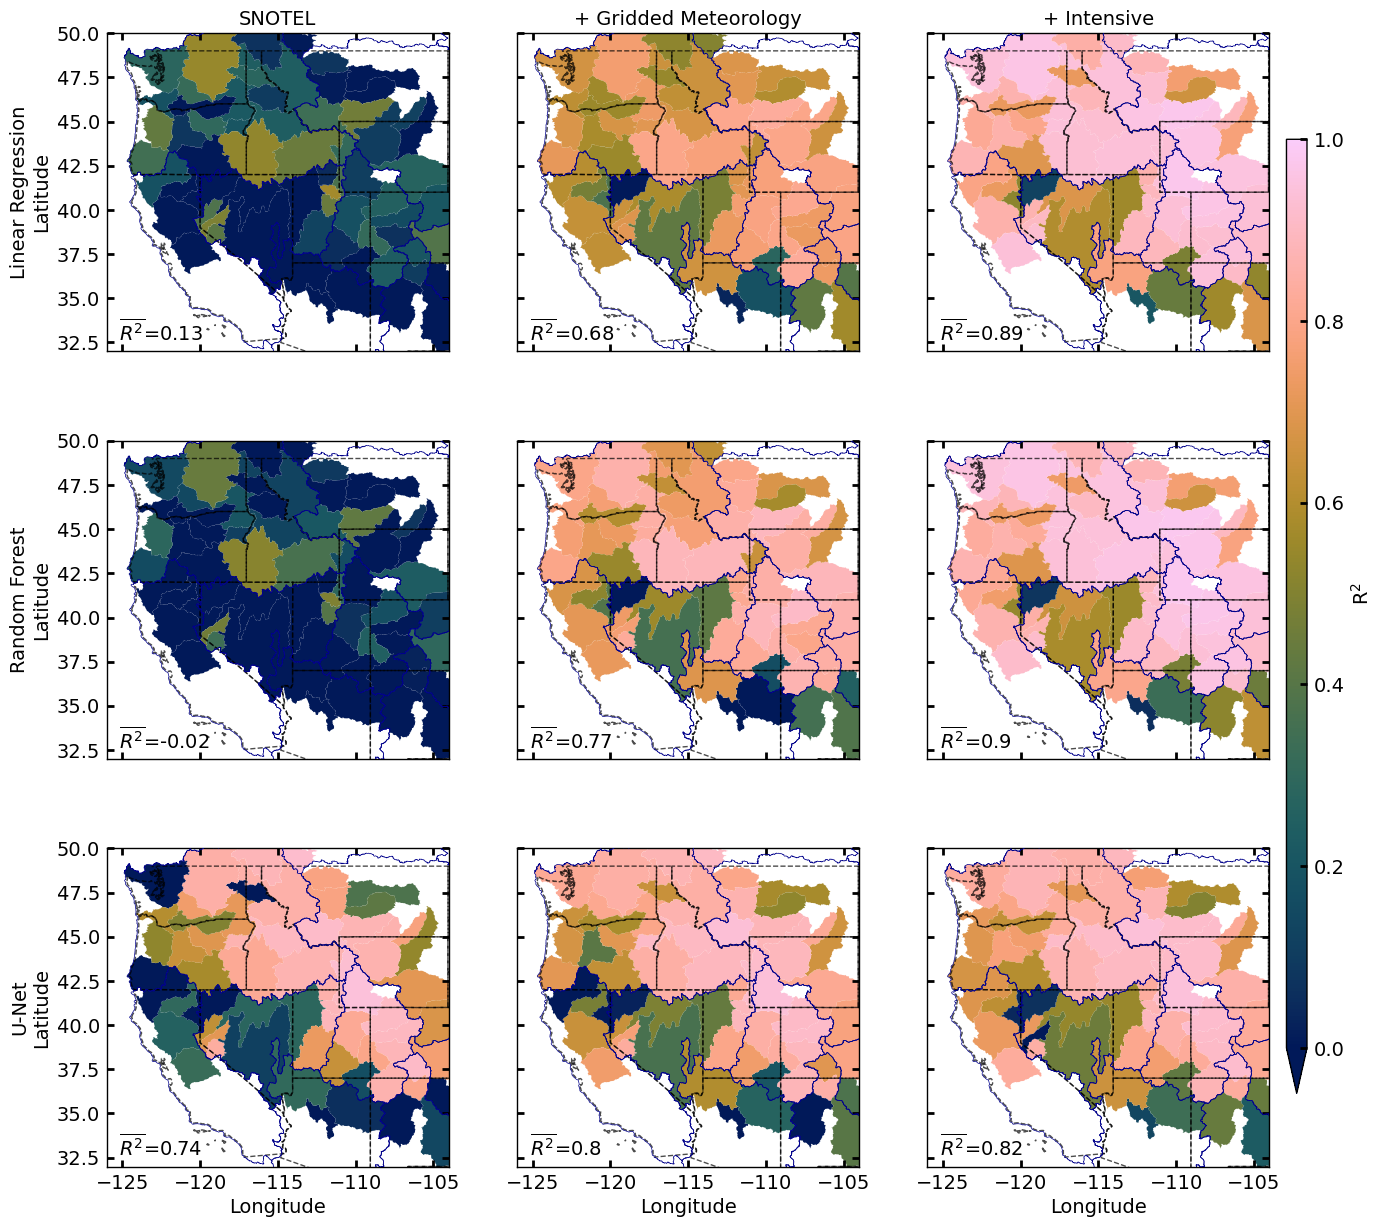

CPU times: user 1min 51s, sys: 1.77 s, total: 1min 53s
Wall time: 1min 52s


In [12]:
%%time
vmin = 0
vmax = 1
norm = Normalize(vmin=vmin, vmax=vmax)
#colormap =  ccm.acton_r #plt.cm.get_cmap("viridis")  
colormap = ccm.batlow
# colormap = plt.cm.get_cmap('jet')
sm = ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])



labels_model = {'linreg': 'Linear Regression', 'RF': 'Random Forest', 'Unet': 'U-Net'} 
titles_datas = {'data_1_2': 'SNOTEL', 'data_3_4': '+ Gridded Meteorology', 'data_5': '+ Intensive'}
plt.rcParams['xtick.major.size'] = 5 
plt.rcParams['ytick.major.size'] = 5
## 1 min 37 seconds
grouptypes = ['data_1_2', 'data_3_4', 'data_5']
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
basincolor = 'darkblue'
for i in range(3):
    data = grouptypes[i] 
    for j, model in enumerate(['linreg', 'RF', 'Unet']):
        ax = axs[j, i]
        colname = f'{model}_{data}'
        cax = grouped_gdf.plot(column=colname, cmap=colormap, ax=ax, vmin=vmin, vmax=vmax, legend=False)
        r2 = round(np.nanmedian(grouped_gdf[colname][grouped_gdf[colname] >-1e2]),2)
        ax.text(-125.2, 32.55, r'$\overline{R^{2}}$='+f'{r2}')
        
        if (i == 2) and (j ==2): 
                cb = ax.scatter([0,0] , [1,1],c = [0,1], cmap = colormap, vmin = vmin, vmax = vmax)                
                cax = ax.inset_axes([1.05, 0.23, 0.06, 3])    ## x index , y index, width , length     
                cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                                     extend='min', label = r'R$^2$')
                
        
        
        if j == 0: ax.set_title(titles_datas[data], fontsize = 14)
        if i > 0: ax.set_yticklabels([])
        else: ax.set_ylabel(f'{labels_model[model]}\nLatitude')
        if j  < 2 : ax.set_xticklabels([])
        else: ax.set_xlabel('Longitude')
        
for ax in axs.flatten():
    
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')
        
    ax.set_xlim((-126, -104))
    ax.set_ylim((32, 50))


fig.savefig(f'{basedir}/figures/fig3.png')

plt.show()


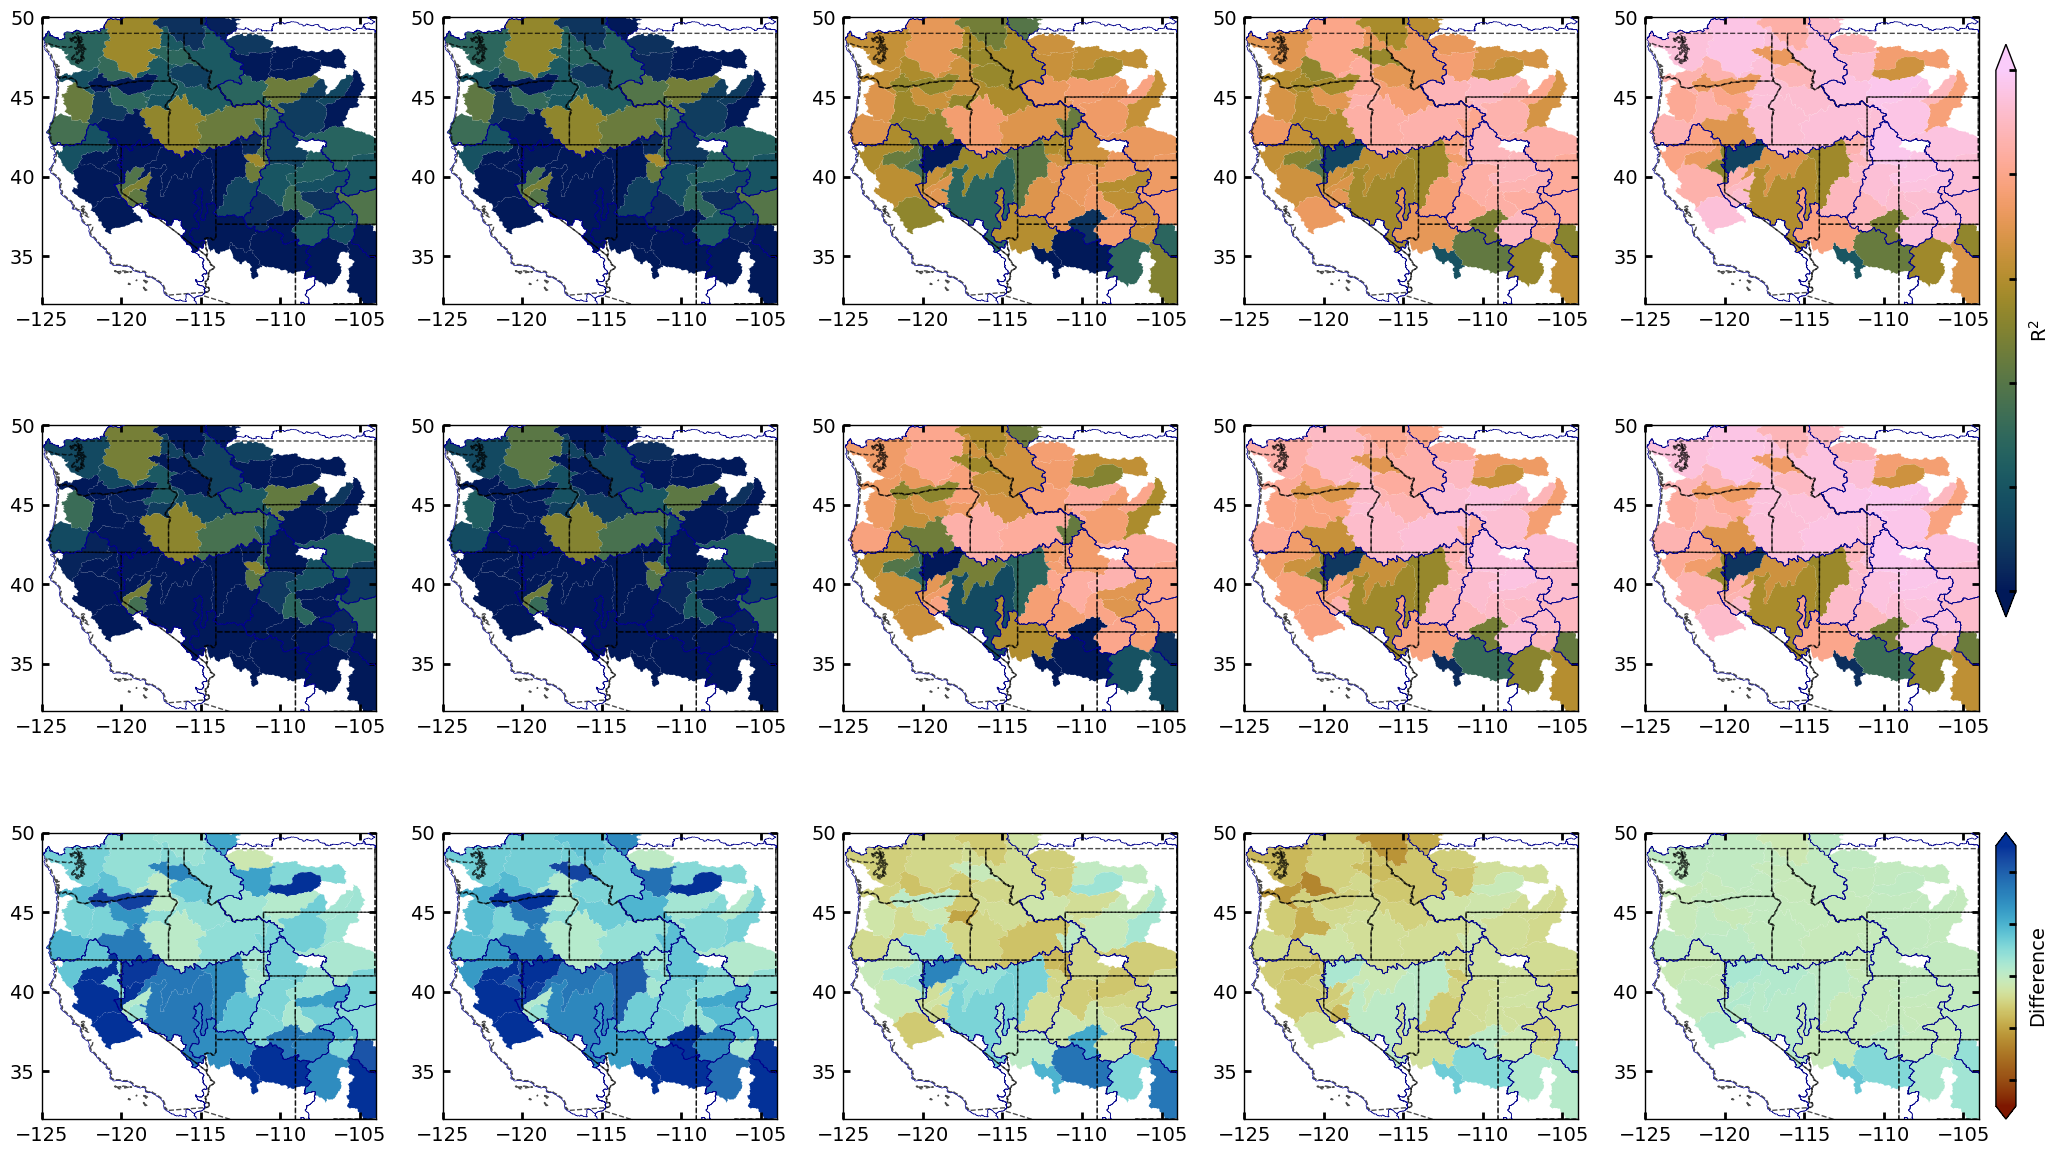

CPU times: user 6min 37s, sys: 2.68 s, total: 6min 40s
Wall time: 6min 39s


In [11]:
%%time
## 6min 40s
fig, axs = plt.subplots(3, 5, figsize=(25, 15))
basincolor = 'darkblue'

for ax in axs.flatten():
    huc2.boundary.plot(ax=ax, linewidth=0.5, color=basincolor, label='Basin boundary', zorder=3)
    states.boundary.plot(ax=ax, linewidth=1, color='black', alpha=0.7, linestyle='--')

for i in range(5):
    data = datas[i]
    for j, model in enumerate(['linreg', 'RF']):
        ax = axs[j, i]
        colname = f'{data}_{model}'
        cax = plotdata.plot(column=colname, cmap=colormap, ax=ax, vmin=0, vmax=1, legend=False)
        if i == 4: 
            if j == 1:
                cb = ax.scatter([0,0] , [1,1],c = [0,1], cmap = colormap, vmin = 0, vmax = 1)                
                cax = ax.inset_axes([1.05, 0.33, 0.06, 2])        
                cbar = plt.colorbar(cb, cax=cax, pad=0.1, orientation='vertical',
                                     extend='both', label = r'R$^2$')
                cbar.set_ticklabels([])
                
        
        ax.set_xlim((-125, -104))
        ax.set_ylim((32, 50))

    ax2 = axs[2, i]
    colname = f'{data}_diff'
    plotdata.plot(column=colname, vmin=-0.5, vmax=0.5, ax=ax2, cmap=colormap2, legend = False)
    cb = ax2.scatter([0,0] , [1,1],c = [0,1], cmap = colormap2, vmin = -0.5, vmax = 0.5)   
    if i == 4:
        cax2 = ax2.inset_axes([1.05, 0, 0.06, 1])        
        cbar = plt.colorbar(cb, cax=cax2, pad=0.1, orientation='vertical',
                             extend='both', label = 'Difference')
        cbar.set_ticklabels([])
    ax2.set_xlim((-125, -104))
    ax2.set_ylim((32, 50))

# plt.tight_layout()
plt.show()
